## 儲存Face Laplacian圖片

In [1]:
import numpy as np
import cv2 as cv
from imutils import paths
import os
import shutil

In [2]:
#自動生成資料夾
path = '.\\Face_Laplacian\\pos'
if not os.path.isdir(path):
    os.makedirs(path)

In [3]:
imagePaths = sorted(list(paths.list_images(".\\Face\\pos")))

i=0
for imagePath in imagePaths:
    img = cv.imread(imagePath)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    #圖像進行Laplacian處理
    laplace = cv.Laplacian(src=gray, ddepth=-1, ksize=3)
    cv.imwrite('.\\Face_Laplacian\\pos\\%d.jpg'%(i), laplace)
    shutil.copy('.\\Face\\pos\\%d.txt'%(i), path) 
    i=i+1   

## 以Laplacian邊緣為特徵的MLP辨識模型

In [5]:
import numpy as np
import matplotlib.pyplot as plt
#from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
np.random.seed(10)
from keras.datasets import mnist
from rcnn.load_data import rcnn_format
from keras.models import Sequential
from keras.layers import Dense

### 訓練模型

In [6]:
def show_image(image):
    fig = plt.gcf()
    fig.set_size_inches(2, 2)
    plt.imshow(image, cmap='binary')
    plt.show() 

def show_images_labels_predictions(images,labels,
                                  predictions,start_id,num=10):
    plt.gcf().set_size_inches(12, 14)
    if num>25: num=25 
    for i in range(0, num):
        ax=plt.subplot(5,5, 1+i)
        #顯示黑白圖片
        ax.imshow(images[start_id], cmap='binary')
        
        # 有 AI 預測結果資料, 才在標題顯示預測結果
        if( len(predictions) > 0 ) :
            title = 'ai = ' + str(predictions[start_id])
            # 預測正確顯示(o), 錯誤顯示(x)
            title += (' (o)' if predictions[start_id]==labels[start_id] else ' (x)') 
            title += '\nlabel = ' + str(labels[start_id])
        # 沒有 AI 預測結果資料, 只在標題顯示真實數值
        else :
            title = 'label = ' + str(labels[start_id,0])
            
        # X, Y 軸不顯示刻度    
        ax.set_title(title,fontsize=12) 
        ax.set_xticks([]);ax.set_yticks([])        
        start_id+=1 
    plt.show()

Load dataset: Face_Laplacian\pos
Train Data shape:(40, 112, 92, 3)
Test Data shape:(10, 112, 92, 3)
Train Label shape:(40, 5)
Test Label shape:(10, 5)


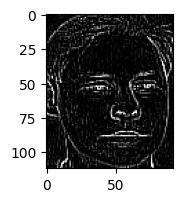

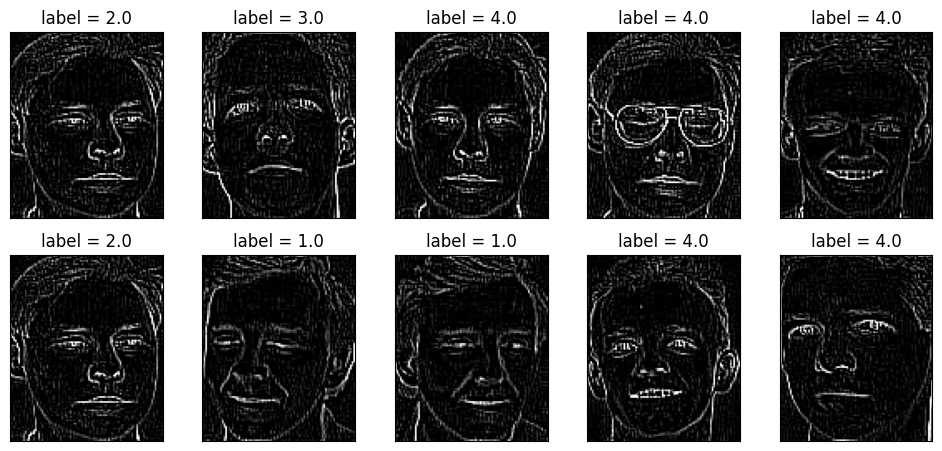

In [7]:
#建立訓練資料和測試資料，包括訓練特徵集、訓練標籤和測試特徵集、測試標籤
(train_feature, train_label),(test_feature, test_label) = rcnn_format('Face_Laplacian', (92, 112, 3))

print("Train Data shape:" + str(train_feature.shape))
print("Test Data shape:" + str(test_feature.shape))
print("Train Label shape:" + str(train_label.shape))
print("Test Label shape:" + str(test_label.shape))

show_image(train_feature[0]) 
show_images_labels_predictions(train_feature,train_label,[],0,10)   

In [8]:
#將 Features 特徵值轉換為 30912個 float 數字的 1 維向量
train_feature_vector =train_feature.reshape(len(train_feature), 30912).astype('float32')
test_feature_vector = test_feature.reshape(len(test_feature), 30912).astype('float32')
#print(train_feature_vector)
print(train_feature_vector.shape)

(40, 30912)


In [9]:
#Features 特徵值標準化
train_feature_normalize = train_feature_vector/255
test_feature_normalize = test_feature_vector/255
#print(train_feature_normalize)

In [11]:
#label 轉換為 One-Hot Encoding 編碼
train_label_onehot = to_categorical(train_label[:,0])
test_label_onehot = to_categorical(test_label[:,0])
print(train_label_onehot)

[[0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


In [12]:
#建立模型
model = Sequential()
#輸入層：30912, 隱藏層：512，輸出層：5
model.add(Dense(units=512, 
                input_dim=30912, 
                kernel_initializer='normal', 
                activation='relu'))
#model.add(Dense(units=512,  
#                kernel_initializer='normal', 
#                activation='relu'))
model.add(Dense(units=5, 
                kernel_initializer='normal', 
                activation='softmax'))
model.summary()  # 模型可視化
#定義訓練方式
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               15827456  
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 15830021 (60.39 MB)
Trainable params: 15830021 (60.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



In [13]:
#以(train_feature_normalize,train_label_onehot)資料訓練，
#訓練資料保留 20% 作驗證,訓練10次、每批次讀取200筆資料，顯示簡易訓練過程
train_history =model.fit(x=train_feature_normalize,
                         y=train_label_onehot,validation_split=0.2, 
                         epochs=20, batch_size=200,verbose=2)

Epoch 1/20


1/1 - 1s - loss: 1.6086 - accuracy: 0.3125 - val_loss: 1.5905 - val_accuracy: 0.3750 - 617ms/epoch - 617ms/step
Epoch 2/20
1/1 - 0s - loss: 1.5768 - accuracy: 0.6562 - val_loss: 1.5700 - val_accuracy: 0.3750 - 106ms/epoch - 106ms/step
Epoch 3/20
1/1 - 0s - loss: 1.5445 - accuracy: 0.6562 - val_loss: 1.5469 - val_accuracy: 0.3750 - 115ms/epoch - 115ms/step
Epoch 4/20
1/1 - 0s - loss: 1.5082 - accuracy: 0.7812 - val_loss: 1.5212 - val_accuracy: 0.3750 - 114ms/epoch - 114ms/step
Epoch 5/20
1/1 - 0s - loss: 1.4677 - accuracy: 0.7812 - val_loss: 1.4935 - val_accuracy: 0.3750 - 114ms/epoch - 114ms/step
Epoch 6/20
1/1 - 0s - loss: 1.4237 - accuracy: 0.7812 - val_loss: 1.4643 - val_accuracy: 0.3750 - 106ms/epoch - 106ms/step
Epoch 7/20
1/1 - 0s - loss: 1.3769 - accuracy: 0.8125 - val_loss: 1.4338 - val_accuracy: 0.3750 - 109ms/epoch - 109ms/step
Epoch 8/20
1/1 - 0s - loss: 1.3278 - accuracy: 0.8125 - val_loss: 1.4022 - val_accuracy: 0.5000 - 102ms/epoch - 102ms/step
Epoch 9/20
1/1

In [14]:
#評估準確率
scores = model.evaluate(test_feature_normalize, test_label_onehot)
print('\n準確率=',scores[1])

1/1 [==============================] - 0s 29ms/step - loss: 0.9696 - accuracy: 0.7000

準確率= 0.699999988079071


In [15]:
#將模型儲存至 HDF5檔案中
model.save('Face_laplacian_model.h5')

c:\01_MLP\nnenv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### 測試模型

In [16]:
predict=model.predict(test_feature_normalize)
prediction=np.argmax(predict,axis=1)

1/1 [==============================] - 0s 66ms/step


In [17]:
# 顯示圖片及預測結果的函數
import random

def plot_images_labels_prediction(images, labels, prediction=[], names=[], predictions_array=[], num=20):
    # 取得 pyplot 物件參考
    fig = plt.gcf()

    # 設定畫布大小為 12 吋*14吋
    fig.set_size_inches(12, 14)

    idx = random.randint(0, images.shape[0] - 1)

    # 限制最多顯示 20 個子圖
    if num > 20: num = 20

    # 依序顯示 num 個子圖
    for i in range(0, num):
        # 建立 5*5 個子圖中的第 i+1 個 
        ax = plt.subplot(5, 5, i + 1)

        # 顯示子圖
        ax.imshow(images[idx], cmap='gray')

        title = ""
        color = 'black'
        label = labels[idx]
        pred = None

        # 有預測值就加入標題中
        if len(prediction) > 0:
            if prediction[idx] != labels[idx]:
                color = 'red'
                confidence = 100 * np.min(predictions_array[idx])
            else:
                color = 'blue'
                confidence = 100 * np.max(predictions_array[idx])
            pred = prediction[idx]
        
        if len(names) > 0:
            # print(names)
            # print(label)
            label = names[label]
            if pred != None:
                pred = names[pred]

        title = "label = " + str(label)
        if pred != None: title += "\npredict = " + str(pred)

        title = "{}\nscore={:2.2f}%".format(title, confidence)

        # 設定標題
        ax.set_title(title, fontsize=10, color=color) 
        
        # 不顯示 x 、y軸刻度
        ax.set_xticks([]);  
        ax.set_yticks([]);
        
        # 樣本序號增量 1
        idx += 1    
        if idx >= images.shape[0]:
            idx = 0
    
    # 繪製圖形
    plt.subplots_adjust(wspace=0.6, hspace=0.6)
    plt.show()

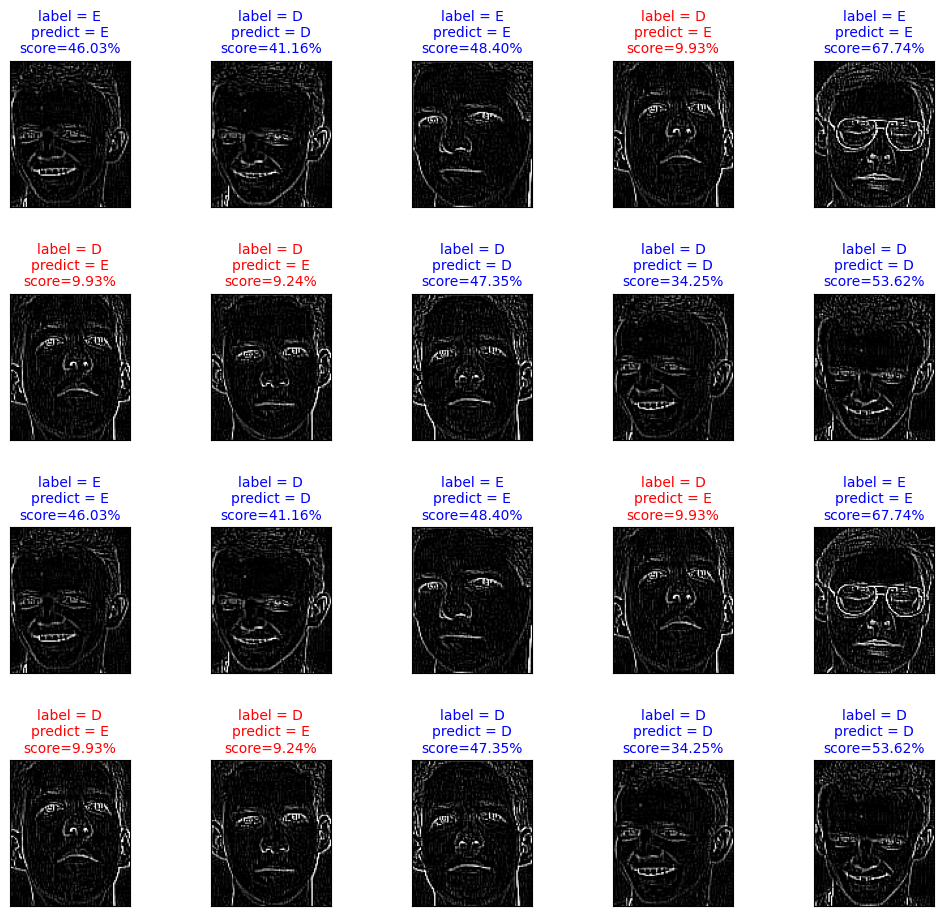

In [18]:
NAMES = ['A', 'B', 'C', 'D', 'E']
plot_images_labels_prediction(test_feature, np.argmax(test_label_onehot, axis=1), np.argmax(predict, axis=1), NAMES, predictions_array=predict)